# Inits

In [97]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

# Reading and formatting data

## Read in data
Gilbert provides two datasets, one containing all the info about the sgRNAs, other one containing all of what he generated about the annotated genes. Both are imported, and distances between 5' of the PAM and both ends of the primary and secondary TSS sites of the gene are calculated, for usage in the model.

In [2]:
# dataframe containing sequences, targeted genes, and scores
df = pd.read_excel("data/elife-19760-supp1-v2.xlsx")
df = df.rename(columns = {"sgRNA sequence": "sequence",
                          "gene symbol": "gene",
                          "distance_to_CAGE": "distance",
                          "sgRNA length (including PAM)": "length",
                          "PAM genomic coordinate [hg19]" : "PAM_coord",
                          "CRISPRi activity score [Horlbeck et al., eLife 2016]": "score"})

# dataframe containing annotated gene locations
gene_df = pd.read_excel("data/elife-19760-supp2-v2.xlsx")
gene_df = gene_df.rename(columns = {"Primary TSS, 5'": "prim_TSS_5p",
                                    "Primary TSS, 3'": "prim_TSS_3p",
                                    "Secondary TSS, 5'": "sec_TSS_5p",
                                    "Secondary TSS, 3'": "sec_TSS_3p"})

# merging the two, determining distance between PAM and TSS
df = pd.merge(df, gene_df, on = ("gene", "chromosome"), how = "left")
df["prim_TSS_dist5p"] = df["PAM_coord"] - df["prim_TSS_5p"]
df["prim_TSS_dist3p"] = df["PAM_coord"] - df["prim_TSS_3p"]
df["sec_TSS_dist5p"] = df["PAM_coord"] - df["sec_TSS_5p"]
df["sec_TSS_dist3p"] = df["PAM_coord"] - df["sec_TSS_3p"]
df = df[(df["prim_TSS_dist5p"] > -3000) & (df["prim_TSS_dist5p"] < 3000)]

## Linearizing TSS distance
Gilbert's paper mentions linearizing primary and secondary distance to TSS using an SVR, and then using the outputs of the SVM as variables for the distance from TSS. Not quite sure why this works, or why they need to be linearized.

### Formatting and binning data
Binning is primarily for visualization (data can be quite crowded), but also can be used for fitting to SVR

C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()
C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\146674775.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()


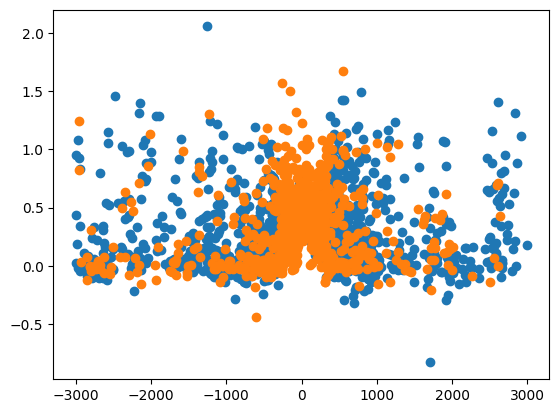

In [3]:
df = df.dropna()
X = df.dropna(subset = "prim_TSS_dist5p").loc[:, ["prim_TSS_dist5p"]]
y = df.dropna(subset = "prim_TSS_dist5p").loc[:, "score"]

# splitting training/test sets
perc_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)

def bin_and_average(df, bins):    
    df["X_bin"] = pd.cut(df["prim_TSS_dist5p"], bins = bins)
    
    bin_means = df.groupby("X_bin")["score"].mean().reset_index()
    bin_means["center"] = bin_means["X_bin"].apply(lambda row: row.left + (np.abs(row.left - row.right) / 2))
    
    return bin_means.dropna()

concat_df = pd.concat([X_train, y_train], axis = 1)
num_bins = 50000
binned_df = bin_and_average(concat_df, int((1 - perc_test) * num_bins))

binned_test_df = bin_and_average(pd.concat([X_test, y_test], axis = 1), int(perc_test * num_bins))

plt.scatter(binned_df["center"], binned_df["score"])
plt.scatter(binned_test_df["center"], binned_test_df["score"])

### Fitting model to SVR
Two statements are given - one is to fit to binned data, other is to fit to actual data. GridSearchCV is commented out because it takes a long time and seems to overfit to the existing data, but should probably be messed around with more in the future.

In [4]:
# fitting SVR
svr = svm.SVR(kernel = "rbf")
parameters = {'C': np.logspace(-2, 2, num = 5),
              "gamma": np.logspace(-8, 0, num = 12)}
grid_svr = GridSearchCV(svr, parameters, n_jobs = -1, scoring = "neg_mean_squared_error")

# fitting to binned data
# grid_svr.fit(binned_df["center"].to_numpy().reshape(-1, 1), binned_df["score"].to_numpy().reshape(-1, 1))
# with open("models/binned_test_SVR.pk1", "wb") as file:
#     pickle.dump(grid_svr, file)
    
with open("models/binned_test_SVR.pk1", "rb") as file:
    grid_svr = pickle.load(file)
print(f"R^2: {grid_svr.score(binned_test_df['center'].to_numpy().reshape(-1, 1), binned_test_df['score'].to_numpy().reshape(-1, 1))}")

# fitting directly to data
# grid_svr.fit(X_train, y_train)
# print(f"R^2: {grid_svr.score(X_test, y_test)}")

R^2: -0.07866193460219982


c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Plotting fit
Plotted with binned values and actual values

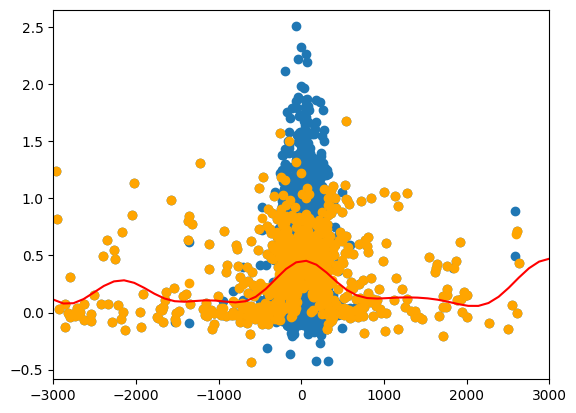

In [5]:
plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(plot_X)

plt.scatter(X_test, y_test)
plt.scatter(binned_test_df["center"], binned_test_df["score"], color = "orange")
plt.plot(plot_X, y_pred, color = "red")
plt.xlim(-3000, 3000)
plt.show()

### Adding linearized distance for all distances
Adding linearized values (obtained from SVM fit) for all four distance vectors. Plots for each for sanity.

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


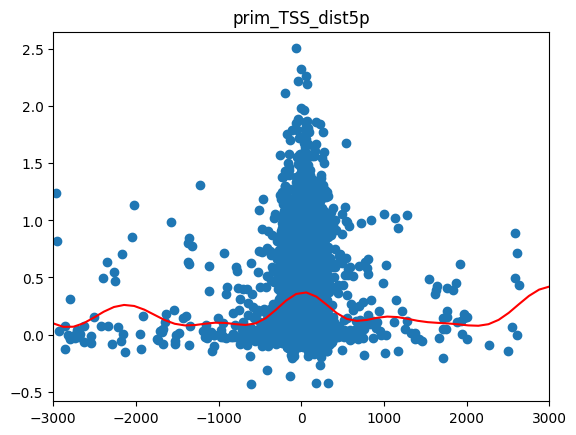

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


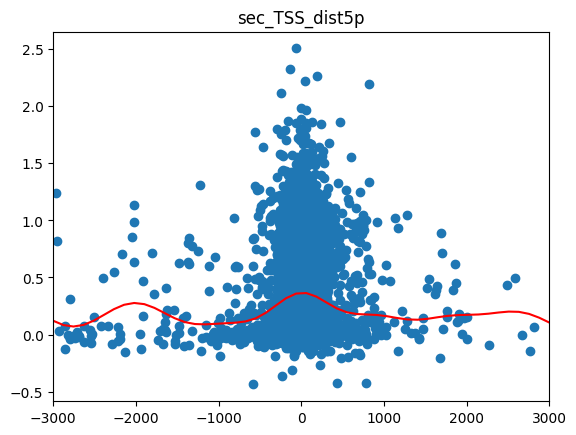

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


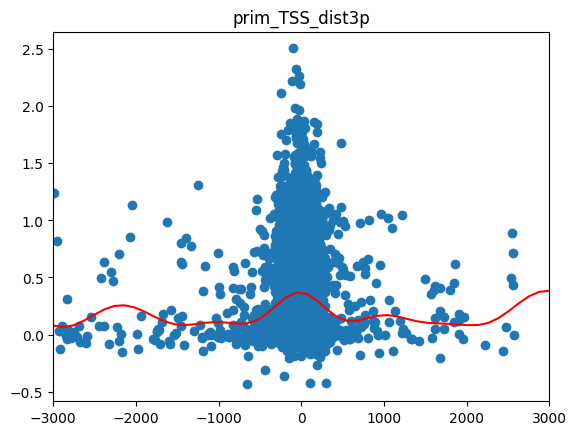

c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.6.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


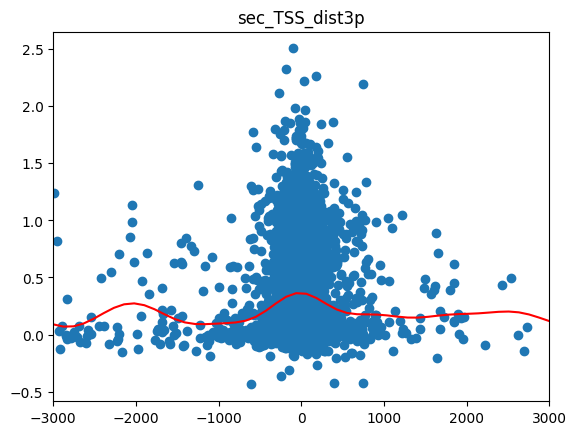

In [6]:
vars = ("prim_TSS_dist5p", "sec_TSS_dist5p", "prim_TSS_dist3p", "sec_TSS_dist3p")

for var in vars:
    # setting up X and y for variable
    X = df.dropna(subset = var).loc[:, [var]]
    y = df.dropna(subset = var).loc[:, "score"]
    
    # splitting training and testing sets based on value defined earlier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)
    # best_svr.fit(X_train, y_train)
    # with open("models/" + var + "_test_SVR.pk1", "wb") as file:
    #     pickle.dump(best_svr, file)
    
    with open("models/" + var + "_test_SVR.pk1", "rb") as file:
        best_svr = pickle.load(file)
    
    # update original dataframe with normalized values
    df[("norm_" + var)] = best_svr.predict(df[var].to_numpy().reshape(-1, 1))
    
    plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
    y_pred = best_svr.predict(plot_X)

    plt.scatter(X_test, y_test)
    plt.plot(plot_X, y_pred, color = "red")
    plt.xlim(-3000, 3000)
    plt.title(var)
    plt.show()

## Adding additional columns for fitting
Adding fraction of each base, GC content

In [7]:
for base in ("A", "C", "T", "G"):
    df[("frac_" + base)] = df.apply(lambda row: row["sequence"].count(base) / row["length"], axis = 1)
    
df["GC_content"] = df["frac_C"] + df["frac_G"]

## One-hot encoding vectors for monomer bases at each position

In [ ]:
max_len = df["sequence"].apply(len).agg(max)
bps = ["A", "C", "T", "G"]

def encode_monomer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(bps)))
    
    for i, bp in enumerate(seq):
        if bp in bps:
            one_hot_vector[i, bps.index(base)] = 1
    return one_hot_vector

encoded_monomers = df["sequence"].apply(lambda x: encode_monomer(x, max_len))

for i in range(max_len):
    for j, base in enumerate(bps):
        df[f"pos_{i+1}_{base}"] = encoded_monomers.apply(lambda x: x[i, j])

C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\844754481.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_len = df["sequence"].apply(len).agg(max)
C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\844754481.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}_{base}"] = encoded.apply(lambda x: x[i, j])
C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\844754481.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

## One-hot encoding vectors for dimers at each position

In [40]:
combo_bps = []
for i, b1 in enumerate(bps):
    for j, b2 in enumerate(bps):
        combo_bps.append(b1 + b2)

def encode_dimer(seq, max_len):
    one_hot_vector = np.zeros((max_len, len(combo_bps)))
    
    # iterating over two bases at a time, in order
    for i in range(len(seq) - 1):
        dimer = seq[i] + seq[i + 1]
        if dimer in combo_bps:
            one_hot_vector[i, combo_bps.index(dimer)] = 1
    return one_hot_vector

encoded = df["sequence"].apply(lambda x: encode_dimer(x, max_len))

for i in range(max_len):
    for j, bases in enumerate(combo_bps):
        df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])

C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])
C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"pos_{i+1}{i+2}_{bases}"] = encoded.apply(lambda x: x[i, j])
C:\Users\Jackson\AppData\Local\Temp\ipykernel_41636\1892224224.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

## Running off-target analysis for each sgRNA
Commented out for now because this will probably take a day to run

In [135]:
# normalize all sgRNAs to have the same length as the max length sgRNA (by adding Ns in front)
max_len = df["sequence"].apply(len).max()

def normalize_str_len(str, max_len):
    while len(str) < max_len:
        str = "N" + str
    return(str)

df["sequence"] = df["sequence"].apply(normalize_str_len, args = (max_len,))

# preparing input strings for cas-offinder
pam = "NGG"
full_pam = ("N" * max_len) + pam

co_input = f"../genomes/human_hg19\n{full_pam} 2 1"
for i, seq in enumerate(df["sequence"], start = 1):
    co_input = co_input + f"\n{seq}NNN 3 Seq{i}"

# write input string to input.txt for cas-offinder
with open("input.txt", "w") as file:
    file.write(co_input)

# running subprocess for cas-offinder (WARNING: MAY TAKE A VERY LONG TIME TO RUN)
subprocess.run(f".\cas-offinder input.txt G output.txt")

co_output = pd.read_csv("output.txt", sep = "\t", comment = "#", header = None)
co_output.columns = ["WT", "chromosome", "posn", "OT", "dir", "mismatches"]

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working.

## Organizing, scaling data

In [141]:
X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "strand", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p"])
y = df.loc[:, "score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Fitting model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

params = {
    "n_estimators": Integer(1, 500),
    "max_depth": Integer(1, 100)
}
grid_rf_reg = BayesSearchCV(rf_reg, params, scoring = "neg_mean_squared_error", n_iter = 1, n_jobs = -1, cv = 5)
_ = grid_rf_reg.fit(X_train, y_train)
# with open("models/RF.pk1", "wb") as file:
#         pickle.dump(grid_rf_reg, file)

# with open("models/RF.pk1", "rb") as file:
#     grid_rf_reg = pickle.load(file)

In [128]:
print(grid_rf_reg.best_score_)
print(grid_rf_reg.score(X_test, y_test))

-0.1596627375006319
-0.15735395346794667


In [129]:
print(grid_rf_reg.best_estimator_)

RandomForestRegressor(max_depth=87, n_estimators=426)


## Comparing model fit with test set

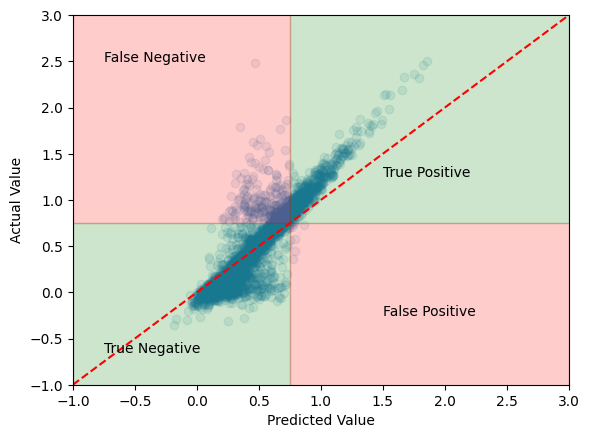

In [144]:
best_rf_reg = grid_rf_reg.best_estimator_
pred_score = best_rf_reg.predict(X)
y_pred = best_rf_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

## ROC curve (and other metrics)

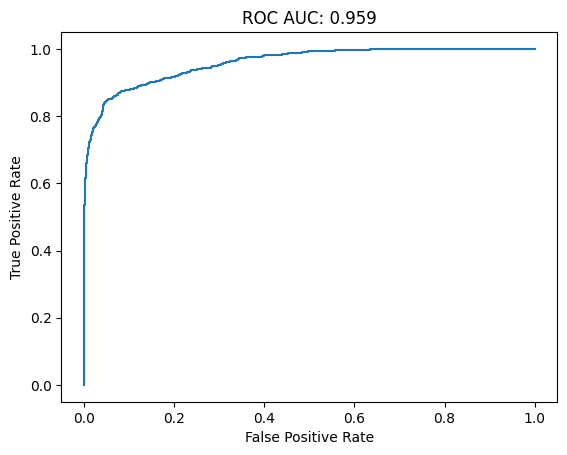

In [147]:
from sklearn.metrics import roc_curve, auc

actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold

fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Gradient Boosting Regression
Allegedly more robust than random forest regression.

In [119]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(reg_lambda = 1)
params = {
    "n_estimators": Integer(250, 750),
    "learning_rate": Real(0.001, 1, prior = "log-uniform"),
    "num_leaves": Integer(2, 1000, prior = "log-uniform"),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1) 
}
grid_lgbm_reg = BayesSearchCV(lgbm_reg, params, scoring = "r2", n_iter = 100, n_jobs = -1, cv = 5)
_ = grid_lgbm_reg.fit(X_train, y_train)
# with open("models/RF.pk1", "wb") as file:
#         pickle.dump(grid_rf_reg, file)
    
# with open("models/RF.pk1", "rb") as file:
#     grid_rf_reg = pickle.load(file)

In [120]:
grid_lgbm_reg.best_estimator_

LGBMRegressor(learning_rate=0.014817264542992741, n_estimators=750,
              num_leaves=53, reg_lambda=1.0)

In [ ]:
best_lgbm_reg = grid_lgbm_reg.best_estimator_
pred_score = best_lgbm_reg.predict(X)
y_pred = best_lgbm_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.show()

ValueError: Number of features of the model must match the input. Model n_features_ is 514 and input n_features is 510

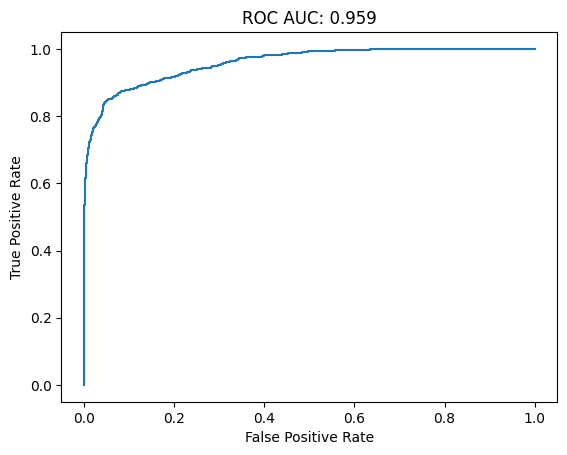

In [146]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold

fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()